In [1]:
import sys
sys.path.append('..')

from data.tile_stitcher import stitch_predictions


In [2]:
# ckpt = '2410/Hagen-joint_indi-l1/36'
# ckpt = '2502/Hagen-joint_indi-l1/57'
# ckpt  = '2412/HT_LIF-joint_indi-l1/8'
# ckpt = '2501/COSEM_jrc-hela-joint_indi-l1/32'
# ckpt = '2502/COSEM_jrc-hela-joint_indi-l1/13'
# ckpt = '2502/HT_LIF24-joint_indi-l1/60'
ckpt = '2502/Hagen-joint_indi-l1/57'
training_rootdir = '/group/jug/ashesh/training/diffsplit/'
num_epochs_normalization = 5
ckpt_time_predictor = '2502/Hagen-UnetClassifier-l2/8' #'2502/Hagen-UnetClassifier-l2/3'#None #'2502/Hagen-UnetClassifier-l2/0'
time_predictor = None
mixing_t_ood = 0.2
mmse_count = 1

num_timesteps = 1
enable_real_input = False
infer_time = True
use_aggregated_inferred_time = False
use_hardcoded_time_for_inference = None


ckpt = ckpt.strip('/').strip(' ')
ckpt

'2502/Hagen-joint_indi-l1/57'

In [3]:
if use_aggregated_inferred_time:
    assert ckpt_time_predictor is not None, 'Time predictor is required for aggregated time inference'
    assert use_hardcoded_time_for_inference is use_hardcoded_time_for_inference, 'Hardcoded time inference is not supported with aggregated time inference'
    assert infer_time is True, 'Time inference must be enabled for aggregated time inference'


if infer_time:
    assert ckpt_time_predictor is not None, 'Time predictor is required for time inference'

if use_hardcoded_time_for_inference is not None:
    assert not infer_time, 'Time inference must be disabled for hardcoded time inference'

assert mixing_t_ood >= 0 and mixing_t_ood <= 1, 'mixing_t_ood must be in [0, 1]'

In [4]:
import yaml
import os
import glob

def model_checkpoint_fpath(fname=None):
    ckpt_dir = os.path.join(training_rootdir, ckpt, 'checkpoint')
    if fname is not None:
        return os.path.join(training_rootdir, ckpt, fname)
    else:
        list_of_files = glob.glob(ckpt_dir +'/*_gen.pth') # * means all if need specific format then *.csv
        latest_file = max(list_of_files, key=os.path.getctime)
        # best_files = [f for f in list_of_files if 'best_gen_' in f]
        # assert len(best_files) == 1,f'{best_files}'
        # best_file = best_files[0]  
        fname = latest_file
        return os.path.join(ckpt_dir,fname)

def model_checkpoint_fpath_prefix(fname=None):
    fpath = model_checkpoint_fpath(fname)
    suffix = '_gen.pth'
    assert fpath.endswith(suffix)
    return fpath[:-len(suffix)]

def load_config(ckpt):
    config_path = os.path.join(training_rootdir,ckpt,'wandb/latest-run/files/config.yaml')

    with open(config_path) as stream:
        
        try:
            opt = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    
    keys = ["name","phase","gpu_ids","path","datasets","model","train", "distributed"]
    output = {}
    for k in keys:
        if k in opt:
            output[k] = opt[k]['value']
    return output

In [5]:
from model.ddpm_modules.time_predictor import TimePredictor
from time_prediction_training import get_datasets
import os
import torch

if ckpt_time_predictor is not None:
    time_pred_ckpt_fpath = os.path.join(training_rootdir, ckpt_time_predictor)

    time_pred_opt = load_config(time_pred_ckpt_fpath)
    time_pred_model_opt = time_pred_opt['model']
    time_predictor = TimePredictor(
        in_channel=time_pred_model_opt['unet']['in_channel'],
        out_channel=time_pred_model_opt['unet']['out_channel'],
        norm_groups=time_pred_model_opt['unet']['norm_groups'],
        inner_channel=time_pred_model_opt['unet']['inner_channel'],
        channel_mults=time_pred_model_opt['unet']['channel_multiplier'],
        attn_res=time_pred_model_opt['unet']['attn_res'],
        res_blocks=time_pred_model_opt['unet']['res_blocks'],
        dropout=time_pred_model_opt['unet']['dropout'],
        image_size=time_pred_opt['datasets']['patch_size'],
        )
    
    time_predictor = time_predictor.cuda()
    time_predictor.load_state_dict(torch.load(os.path.join(time_pred_ckpt_fpath,'best_time_predictor.pth')), strict=True)
    time_predictor.eval()
    print('Loaded time predictor from', time_pred_ckpt_fpath)


TimePredictor
Loaded time predictor from /group/jug/ashesh/training/diffsplit/2502/Hagen-UnetClassifier-l2/8


In [6]:
opt = load_config(ckpt)
opt['path']['resume_state'] = model_checkpoint_fpath_prefix()
# opt['path']['resume_state'] = os.path.join(os.path.dirname(opt['path']['resume_state']),'I110000_E1375')
print(opt['path']['resume_state'])

opt['model']['beta_schedule']['val']['n_timestep'] = num_timesteps
if opt['datasets']['train']['name'] == 'COSEM_jrc-hela':
    opt['datasets']['val']['datapath'] = opt['datasets']['val']['datapath'].replace('val_jrc_hela','test_jrc_hela')

elif opt['datasets']['train']['name'] == 'hagen':
    opt['datasets']['val']['datapath'] = {
    'ch0': '/group/jug/ashesh/data/diffsplit_hagen/test/test_actin-60x-noise2-highsnr.tif',
    'ch1': '/group/jug/ashesh/data/diffsplit_hagen/test/test_mito-60x-noise2-highsnr.tif'
    }
elif opt['datasets']['train']['name'] in ['HT_LIF24','HT_LIF']:
    opt['datasets']['val']['datapath'] = opt['datasets']['val']['datapath'].replace('/val','/test')


/group/jug/ashesh/training/diffsplit/2502/Hagen-joint_indi-l1/57/checkpoint/I450000_E2813


In [7]:
if 'patch_size' not in opt['datasets']:
    opt['datasets']['patch_size']  = opt['datasets']['train']['patch_size']

if 'max_qval' not in opt['datasets']:
    opt['datasets']['max_qval']  = 0.98

if 'uncorrelated_channels' not in opt['datasets']['train']:
    opt['datasets']['train']['uncorrelated_channels']  = False

if enable_real_input:
    opt['datasets']['train']['real_input_fraction'] = 1.0
    opt['datasets']['val']['real_input_fraction'] = 1.0

opt['datasets']['normalize_channels'] = False

In [8]:
import torch
import data as Data
import model as Model
from data.split_dataset import SplitDataset, DataLocation
from split import get_datasets
import os


# data
train_set, val_set = get_datasets(opt, tiled_pred=True)

# model
diffusion = Model.create_model(opt)
diffusion.set_new_noise_schedule(opt['model']['beta_schedule'][opt['phase']], schedule_phase=opt['phase'])

# load checkpoint
diffusion.load_network()

HARDCODED upperclip to 1993. Disable it if not needed !!!
Computing mean and std for normalization
[SplitDataset] Data: 80x2x(2048, 2048) Patch:512 Random:1 Aug:True Q:1.0 UpperClip:0Uncor:False InpFrmNormTar
HARDCODED upperclip to 1993. Disable it if not needed !!!
[TilingDataset] Data: 10x2x(2048, 2048) Patch:512 Random:0 Aug:False Q:1.0 UpperClip:0Uncor:False InpFrmNormTar
[IndiFullTranslation]: Sampling mode: linear_indi, Noise mode: gaussian
[IndiFullTranslation]: Sampling mode: linear_indi, Noise mode: gaussian
[JointIndi]: w_input_loss: 0.1 
Scheduler set to ReduceLROnPlateau with patience:  100

--------------------------------------------------
Number of trainable parameters: 4.88M
--------------------------------------------------



In [9]:
from split import get_xt_normalizer
val_set.set_random_patching(True)
xt_normalizer1, xt_normalizer2 = get_xt_normalizer(val_set,opt['datasets']['train'], num_bins=100, 
                                                   num_epochs=num_epochs_normalization)
val_set.set_random_patching(False)

Random patching set to True


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:22<00:00,  2.79s/it]

Random patching set to False


In [10]:
xt_normalizer1.data_mean, xt_normalizer1.data_std

(tensor([354.5424, 357.5096, 349.8167, 350.1638, 348.0327, 352.2574, 345.6211,
         344.0077, 341.6041, 343.8158, 343.2693, 333.2112, 334.7113, 336.3390,
         332.1515, 330.7975, 327.8687, 330.7887, 333.5966, 327.3449, 323.8900,
         327.7625, 321.0281, 317.3679, 325.2991, 315.5648, 323.9248, 316.6479,
         319.2917, 315.0452, 311.3465, 318.0024, 309.8029, 313.4224, 310.5592,
         316.8623, 301.0292, 306.0782, 304.3927, 305.9294, 304.6825, 296.4751,
         300.6106, 298.3732, 298.4661, 294.9773, 293.1820, 296.0948, 283.9366,
         287.5586, 296.2617, 285.9536, 282.6846, 283.8335, 283.2713, 282.8299,
         279.0562, 278.1547, 273.4341, 271.5943, 265.8005, 272.1021, 270.9902,
         267.6856, 269.9854, 267.2119, 269.2485, 265.7796, 266.6292, 265.5025,
         264.4859, 260.4738, 259.8281, 261.4361, 256.6637, 259.8304, 252.2509,
         250.1383, 256.3028, 250.9250, 250.3573, 247.0338, 246.4885, 244.4132,
         249.4706, 239.9864, 243.6724, 245.6382, 240

In [11]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd



In [12]:
import numpy as np
import random

def get_input_dict(data_dict):
    if opt['datasets']['train']['name'] in ['HT_LIF', 'HT_LIF24']:
        diffusion_data = {'input': data_dict['input'].cuda(), 'target': data_dict['target'].cuda()}
    # elif opt['datasets']['train']['name'] == 'Hagen':
    #     diffusion_data = {'input': data_dict['target'].mean(dim=1,keepdims=True).cuda(), 'target': data_dict['target'].cuda()}
    elif opt['datasets']['train']['name'] in ['Hagen','COSEM_jrc-hela']:
        if enable_real_input:
            assert 'input' in data_dict and data_dict['input'].std() > 0, 'Input is not available'
            diffusion_data = {'input': data_dict['input'].cuda(), 'target': data_dict['target'].cuda()}
        else:
            diffusion_data = {'input': data_dict['target'].mean(dim=1,keepdims=True).cuda(), 'target': data_dict['target'].cuda()}
            inp = diffusion_data['input']
            diffusion_data['input'] = xt_normalizer1.normalize(inp, torch.Tensor([0.5]*len(inp)), update=False)
        
    return diffusion_data

def fix_seeds():
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    torch.backends.cudnn.deterministic = True

fix_seeds()

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch

norm_dict = val_set.get_input_target_normalization_dict()
nimgs = 6
dloader = torch.utils.data.DataLoader(
            val_set,
            batch_size=nimgs,
            shuffle=True,
            num_workers=0,
            pin_memory=True)
for batch_data in dloader:
    break

diffusion_batch_input = get_input_dict(batch_data)

In [14]:
norm_dict.keys()

dict_keys(['mean_input', 'std_input', 'mean_channel', 'std_channel'])

In [15]:
def get_prediction(data_dict, infer_time=True):
    input_unnorm, target_unnorm, pred_unnorm = get_prediction_raw(data_dict, infer_time=infer_time)
    target_unnorm = target_unnorm.transpose(0,2,3,1)
    pred_unnorm = pred_unnorm.transpose(0,2,3,1)
    input_unnorm = input_unnorm.transpose(0,2,3,1)
    return input_unnorm, target_unnorm, pred_unnorm

def get_prediction_raw(data_dict, infer_time=True):
    assert 'input' in data_dict
    assert 'target' in data_dict
    assert len(data_dict['input'].shape) == 4
    assert len(data_dict['target'].shape) == 4
    t_float_start = 0.5
    if time_predictor is not None and infer_time:
        t_float_start = time_predictor(data_dict['input'].cuda())
        
    # NOTE: infer_time=False must be set for recent models.
    prediction = diffusion.netG.inference(data_dict['input'], infer_time=False, t_float_start=t_float_start).detach().cpu().numpy()
    input = data_dict['input'].cpu().numpy()
    target = data_dict['target'].cpu().numpy()

    
    # unnormalize 
    assert len(prediction.shape) == 4
    pred_unnorm = prediction * norm_dict['std_target'] + norm_dict['mean_target']
    target_unnorm = target * norm_dict['std_target'] + norm_dict['mean_target']
    input_unnorm = input * norm_dict['std_input'] + norm_dict['mean_input']


    if opt['datasets']['train']['name'] == 'cifar10':
        pred_unnorm[pred_unnorm<0] = 0
        pred_unnorm[pred_unnorm>255] = 255
        pred_unnorm = pred_unnorm.astype(np.uint8)
        target_unnorm = target_unnorm.astype(np.uint8)
        input_unnorm = input_unnorm.astype(np.uint16)

    return input_unnorm, target_unnorm, pred_unnorm

In [16]:
diffusion.set_new_noise_schedule(opt['model']['beta_schedule']['val'], schedule_phase='val')


In [17]:
import seaborn as sns
# show_hist = False
# if show_hist:
#     ncols = predictions.shape[-1]
#     _,ax = plt.subplots(figsize=(3*ncols,3),ncols=ncols)
#     for ch_idx in range(ncols):
#         sns.histplot(targets[:,...,ch_idx].reshape(-1,), label='target',ax=ax[ch_idx])
#         sns.histplot(predictions[:,-1,...,ch_idx].reshape(-1,), label='prediction', ax=ax[ch_idx])
#     plt.legend()
#     plt.tight_layout()

## Quantitative Evaluation using the classifier.
Here, we also inspect the effect of MMSE count.

In [18]:

if time_predictor is not None:
    t_pred1 = []
    t_pred2 = []
    with torch.no_grad():
        for i in tqdm(range(len(val_set))):
            data = val_set[i]
            inp_indi1 = data['target'][:1]*(1-mixing_t_ood) + data['target'][1:2]*mixing_t_ood
            inp_indi2 = data['target'][:1]*mixing_t_ood + data['target'][1:2]*(1-mixing_t_ood)
            inp_indi1 = torch.Tensor(inp_indi1[None]).cuda()
            inp_indi2 = torch.Tensor(inp_indi2[None]).cuda()
            # we can use mixing_t_ood for the normalization, because if it is real image, then we anyway have to normalize it separately.
            norm_inp1 = xt_normalizer1.normalize(inp_indi1.cuda(), torch.Tensor([mixing_t_ood]*len(inp_indi1)).cuda(), update=False)
            norm_inp2 = xt_normalizer2.normalize(inp_indi2.cuda(), torch.Tensor([mixing_t_ood]*len(inp_indi2)).cuda(), update=False)
            
            # time predictor notion of time is 1 - t, This formulation ensures that we have the time corresponding to indi1.
            t1 = 1 - time_predictor(norm_inp1)
            t2 = 1 - time_predictor(norm_inp2)
            t_pred1.append(t1.item())
            t_pred2.append(t2.item())

    t_pred1_aggregated = np.mean(t_pred1) 
    t_pred2_aggregated = np.mean(t_pred2)
    print(t_pred1_aggregated, t_pred2_aggregated)
else:
    t_pred1_aggregated = None
    t_pred2_aggregated = None

  0%|          | 0/490 [00:00<?, ?it/s]

100%|██████████| 490/490 [00:20<00:00, 24.43it/s]

0.2168390653571304 0.7881763554349237


In [34]:
use_aggregated_inferred_time = False
# use_hardcoded_time_for_inference = 0.5
infer_time = False

In [35]:
from core.psnr import PSNR
from collections import defaultdict
from tqdm import tqdm
import numpy as np

def sanitize_t(t_val, eps = 1e-6):
    t_val = np.clip(t_val, 0+eps, 1-eps)
    return t_val

print('infer_time', infer_time, 'use_aggregated_inferred_time', use_aggregated_inferred_time, 'use_hardcoded_time_for_inference', use_hardcoded_time_for_inference)
indi_model = diffusion.netG
psnr_dict_ood = defaultdict(list)
all_targets_ood = []
all_inputs_ood = []
eps = 1e-6

pred_t_1_arr = []
pred_t_2_arr = []
mmse_pred_bt_removed_arr = []
mmse_pred_dim_arr = []
with torch.no_grad():
    for mmse_idx in range(mmse_count):
        all_predictions_bt_removed = []
        all_predictions_dim_pred = []

        for i in tqdm(range(len(val_set))):
            data = val_set[i]
            inp_indi1 = data['target'][:1]*(1-mixing_t_ood) + data['target'][1:2]*mixing_t_ood
            inp_indi2 = data['target'][1:2]*(1-mixing_t_ood) + data['target'][:1]*mixing_t_ood

            inp_indi1 = torch.Tensor(inp_indi1[None]).cuda()
            inp_indi2 = torch.Tensor(inp_indi2[None]).cuda()
            # we can use mixing_t_ood for the normalization, because if it is real image, then we anyway have to normalize it separately.
            norm_inp1 = xt_normalizer1.normalize(inp_indi1.cuda(), torch.Tensor([mixing_t_ood]*len(inp_indi1)).cuda(), update=False)
            norm_inp2 = xt_normalizer2.normalize(inp_indi2.cuda(), torch.Tensor([mixing_t_ood]*len(inp_indi2)).cuda(), update=False)


            # picking the time
            if infer_time:
                if use_aggregated_inferred_time:
                    predt_inp1 = t_pred1_aggregated
                    predt_inp2 = t_pred2_aggregated
                else:
                    assert use_hardcoded_time_for_inference is None, 'Hardcoded time inference is not supported with individual time inference'
                    predt_inp1 = 1 - time_predictor(norm_inp1).item()
                    predt_inp2 = 1 - time_predictor(norm_inp2).item()
            elif use_hardcoded_time_for_inference is not None:
                predt_inp1 = use_hardcoded_time_for_inference
                predt_inp2 = use_hardcoded_time_for_inference
            else:
                predt_inp1 = mixing_t_ood
                predt_inp2 = 1 - mixing_t_ood
            predt_inp1 = sanitize_t(predt_inp1)
            predt_inp2 = sanitize_t(predt_inp2)




            ch1_bt_removed = indi_model.indi1.inference(norm_inp1, num_timesteps=1, t_float_start=predt_inp1)
            ch2_bt_removed = indi_model.indi2.inference(norm_inp2,  num_timesteps=1, t_float_start=1-predt_inp2)
            
            ch2_dim_pred = indi_model.indi2.inference(norm_inp1, num_timesteps=1, t_float_start=1-predt_inp1)
            ch1_dim_pred = indi_model.indi1.inference(norm_inp2, num_timesteps=1, t_float_start=predt_inp2)

            if mmse_idx == 0:
                all_inputs_ood.append(np.concatenate([inp_indi1.cpu().numpy(), inp_indi2.cpu().numpy()], axis=1))
            pred_t_1_arr.append(predt_inp1)
            pred_t_2_arr.append(predt_inp2)

            
            pred_bt_removed = np.concatenate([ch1_bt_removed.cpu().numpy(), ch2_bt_removed.cpu().numpy()], axis=1)
            pred_dim_pred = np.concatenate([ch1_dim_pred.cpu().numpy(), ch2_dim_pred.cpu().numpy()], axis=1)
            # NOTE: unnormalize
            
            tar_unnorm = data['target']
            if mmse_idx == 0:
                all_targets_ood.append(tar_unnorm[None])
            
            all_predictions_bt_removed.append(pred_bt_removed)
            all_predictions_dim_pred.append(pred_dim_pred)

        all_predictions_bt_removed = np.concatenate(all_predictions_bt_removed, axis=0)
        all_predictions_dim_pred = np.concatenate(all_predictions_dim_pred, axis=0)

        mmse_pred_bt_removed_arr.append(all_predictions_bt_removed)
        mmse_pred_dim_arr.append(all_predictions_dim_pred)
    
all_targets_ood = np.concatenate(all_targets_ood, axis=0)
all_inputs_ood = np.concatenate(all_inputs_ood, axis=0)

pred_t_1_arr = np.array(pred_t_1_arr)
pred_t_2_arr = np.array(pred_t_2_arr)


infer_time False use_aggregated_inferred_time False use_hardcoded_time_for_inference None


  0%|          | 0/490 [00:00<?, ?it/s]

100%|██████████| 490/490 [01:08<00:00,  7.17it/s]


In [36]:
mmse_pred_bt_removed = 0 
mmse_pred_dim_pred = 0
for i in range(mmse_count):
    mmse_pred_bt_removed += mmse_pred_bt_removed_arr[i]/mmse_count
    mmse_pred_dim_pred += mmse_pred_dim_arr[i]/mmse_count

In [37]:
from data.tile_stitcher import stitch_predictions

pred_bt_removed_stitched = stitch_predictions(mmse_pred_bt_removed, val_set.tile_manager)
pred_dim_pred_stitched = stitch_predictions(mmse_pred_dim_pred, val_set.tile_manager)
tar_stitched = stitch_predictions(all_targets_ood, val_set.tile_manager)
inputs_stitched_ood = stitch_predictions(all_inputs_ood, val_set.tile_manager)

mean_val = xt_normalizer1.data_mean[[0, -1]].cpu().numpy().reshape(1,1,1,-1)
std_val = xt_normalizer1.data_std[[0, -1]].cpu().numpy().reshape(1,1,1,-1)

pred_bt_removed_stitched = pred_bt_removed_stitched*std_val + mean_val
pred_dim_pred_stitched = pred_dim_pred_stitched*std_val + mean_val
# target_stitched_ood = np.stack(val_set._data_dict, axis=-1)

[10, 2048, 2048, 2]
[10, 2048, 2048, 2]
[10, 2048, 2048, 2]
[10, 2048, 2048, 2]


In [45]:
# from metrics import RangeInvariantPsnr
# bt_rem = RangeInvariantPsnr(tar_stitched[...,0], pred_bt_removed_stitched[...,0]).mean().item(), RangeInvariantPsnr(tar_stitched[...,1], pred_bt_removed_stitched[...,1]).mean().item()
# dim_pred = RangeInvariantPsnr(tar_stitched[...,0], pred_dim_pred_stitched[...,0]).mean().item(), RangeInvariantPsnr(tar_stitched[...,1], pred_dim_pred_stitched[...,1]).mean().item()
# print('BT removed', bt_rem)
# print('Dim pred', dim_pred)

In [40]:
from metrics import compute_stats
bt_removed_stats_dict = compute_stats(tar_stitched, pred_bt_removed_stitched)
dim_pred_stats_dict = compute_stats(tar_stitched, pred_dim_pred_stitched)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth


100%|██████████| 10/10 [00:04<00:00,  2.46it/s]
/home/ashesh.ashesh/code/microSSIM/src/microssim/ssim/ssim_utils.py:297: RuntimeWarning: invalid value encountered in sqrt
  term = 2 * alpha * np.sqrt(elements.vx * elements.vy) + elements.C2
100%|██████████| 10/10 [00:04<00:00,  2.50it/s]


PSNR:	 39.01+-0.627	41.72+-0.627
MicroSSIM:	 0.982+-0.002	0.987+-0.001
MicroS3IM:	 0.991+-0.001	0.996+-0.001
SSIM:	 0.967+-0.001	0.991+-0.001
MSSSIM:	 0.990+-0.001	0.995+-0.001
lpips:	 0.011+-0.001	0.014+-0.002
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth


100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


PSNR:	 30.74+-0.758	27.98+-0.745
MicroSSIM:	 0.913+-0.004	0.881+-0.006
MicroS3IM:	 0.956+-0.002	0.915+-0.006
SSIM:	 0.898+-0.003	0.913+-0.006
MSSSIM:	 0.954+-0.002	0.920+-0.007
lpips:	 0.077+-0.004	0.149+-0.009


In [41]:
def ssim_str(ssim_tmp):
    return f"{np.round(ssim_tmp[0], 3):.3f}+-{np.round(ssim_tmp[1], 3):.4f}"

def psnr_str(psnr_tmp):
    return f"{np.round(psnr_tmp[0], 2)}+-{np.round(psnr_tmp[1], 3)}"

def print_stats_dict(stats_dict, prefix=''):
    print(
        prefix, "PSNR:\t", "\t".join([psnr_str(psnr_tmp) for psnr_tmp in stats_dict['rangeinvpsnr']])
    )
    print(
        prefix, "MicroSSIM:\t",
        "\t".join([ssim_str(ssim) for ssim in stats_dict['microssim']]),
    )
    print(
        prefix, "MicroS3IM:\t", "\t".join([ssim_str(ssim) for ssim in stats_dict['ms3im']])
    )
    print(prefix, "SSIM:\t", "\t".join([ssim_str(ssim) for ssim in stats_dict['ssim']]))
    print(prefix, "MSSSIM:\t", "\t".join([ssim_str(ssim) for ssim in stats_dict['msssim']]))
    # lpiips
    print(prefix, "lpips:\t", "\t".join([ssim_str(lpips) for lpips in stats_dict['lpips']]))

print('Ckpt:',ckpt)

if ckpt_time_predictor is not None:
    print('Classifier:',ckpt_time_predictor)

infer_time, 'use_aggregated_inferred_time', use_aggregated_inferred_time, 'use_hardcoded_time_for_inference', use_hardcoded_time_for_inference

msg  = f'T:{num_timesteps} W:{mixing_t_ood} RealInp:{enable_real_input} M:{mmse_count} TPred:{infer_time} TPredAgg:{use_aggregated_inferred_time}'
msg += f' TPredFixed:{use_hardcoded_time_for_inference}'

msg += f'Norm:{num_epochs_normalization} InfSteps:{num_timesteps}\n'

print(msg)
print_stats_dict(bt_removed_stats_dict, 'BT Removed:')
print('')
print_stats_dict(dim_pred_stats_dict, 'Weak Ch Pred:')


Ckpt: 2502/Hagen-joint_indi-l1/57
Classifier: 2502/Hagen-UnetClassifier-l2/8
T:1 W:0.2 RealInp:False M:1 TPred:False TPredAgg:False TPredFixed:NoneNorm:5 InfSteps:1

BT Removed: PSNR:	 39.01+-0.627	41.72+-0.627
BT Removed: MicroSSIM:	 0.982+-0.0020	0.987+-0.0010
BT Removed: MicroS3IM:	 0.991+-0.0010	0.996+-0.0010
BT Removed: SSIM:	 0.967+-0.0010	0.991+-0.0010
BT Removed: MSSSIM:	 0.990+-0.0010	0.995+-0.0010
BT Removed: lpips:	 0.011+-0.0010	0.014+-0.0020

Weak Ch Pred: PSNR:	 30.74+-0.758	27.98+-0.745
Weak Ch Pred: MicroSSIM:	 0.913+-0.0040	0.881+-0.0060
Weak Ch Pred: MicroS3IM:	 0.956+-0.0020	0.915+-0.0060
Weak Ch Pred: SSIM:	 0.898+-0.0030	0.913+-0.0060
Weak Ch Pred: MSSSIM:	 0.954+-0.0020	0.920+-0.0070
Weak Ch Pred: lpips:	 0.077+-0.0040	0.149+-0.0090


Text(0, 0.5, 'Target')

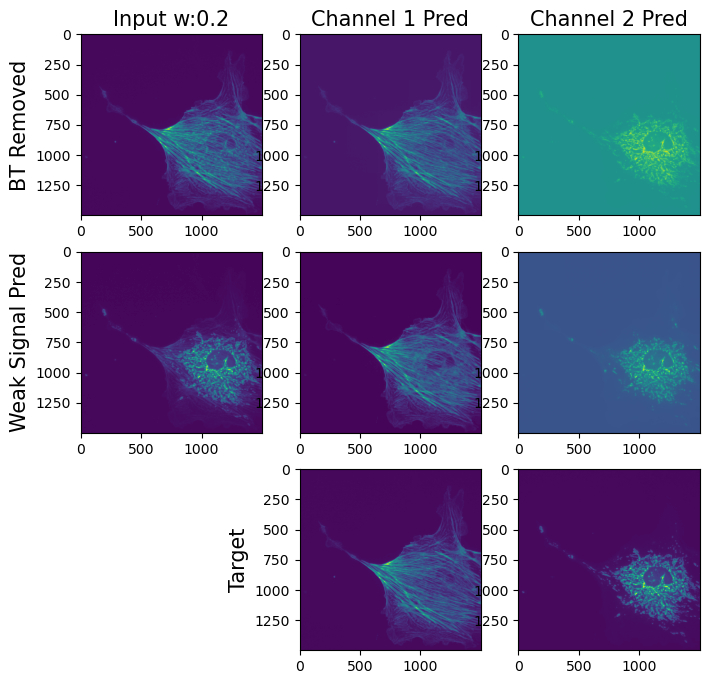

In [44]:
import matplotlib.pyplot as plt

_,ax = plt.subplots(figsize=(8,8),ncols=3,nrows=3)
img_idx = 0
hs = 0 
ws = 0
sz = 1500
# inputs
ax[0,0].set_title(f'Input w:{mixing_t_ood}', fontsize=15)
ax[0,0].imshow(inputs_stitched_ood[img_idx,hs:hs+sz,ws:ws+sz,0])
ax[1,0].imshow(inputs_stitched_ood[img_idx,hs:hs+sz,ws:ws+sz,1])

#  ch1 predictions
ax[0,1].set_title('Channel 1 Pred', fontsize=15)
ax[0,1].imshow(pred_bt_removed_stitched[img_idx,hs:hs+sz,ws:ws+sz,0])
ax[1,1].imshow(pred_dim_pred_stitched[img_idx,hs:hs+sz,ws:ws+sz,0])

# ch2 predictions
ax[0,2].set_title('Channel 2 Pred', fontsize=15)
ax[0,2].imshow(pred_bt_removed_stitched[img_idx,hs:hs+sz,ws:ws+sz,1])
ax[1,2].imshow(pred_dim_pred_stitched[img_idx,hs:hs+sz,ws:ws+sz,1])

ax[0,0].set_ylabel('BT Removed', fontsize=15)
ax[1,0].set_ylabel('Weak Signal Pred', fontsize=15)

# target
ax[2,0].axis('off')
ax[2,1].imshow(tar_stitched[img_idx,hs:hs+sz,ws:ws+sz,0])
ax[2,2].imshow(tar_stitched[img_idx,hs:hs+sz,ws:ws+sz,1])
ax[2,1].set_ylabel('Target', fontsize=15)

## Saving the predictions

In [43]:
param_str = f"T-{mixing_t_ood}_MMSE-{mmse_count}_InferT-{int(infer_time)}_InferTAgg-{int(use_aggregated_inferred_time)}_FixedT-{use_hardcoded_time_for_inference}"
result_dir = os.path.join('/group/jug/ashesh/indiSplit/', 'predictions',param_str)
os.makedirs(result_dir, exist_ok=True)
print(result_dir)

predictions/T-0.2_MMSE-1_InferT-0_InferTAgg-0_FixedT-None


In [33]:
from skimage.io import imread, imsave
def save_tiff(path, data):
    imsave(path, data, plugin='tifffile')


# save_tiff(os.path.join(result_dir,'bt_removed_pred.tif'), pred_bt_removed_stitched)
# save_tiff(os.path.join(result_dir,'dim_pred.tif'), pred_dim_pred_stitched)
# pred_bt_removed_stitched.shape, pred_bt_removed_stitched.shape

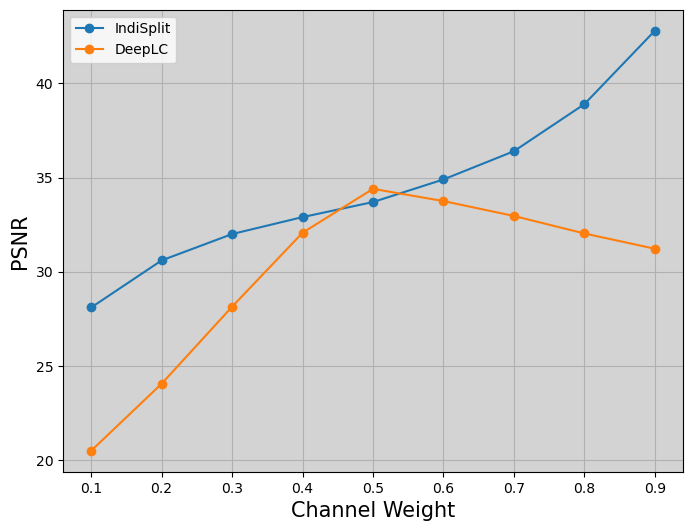

In [27]:
import matplotlib.pyplot as plt

w = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
indisplit = [28.1, 30.6, 32.0, 32.9, 33.7,34.9,36.4, 38.9, 42.8 ]
deepLC = [20.49, 24.05, 28.14, 32.07, 34.4, 33.75, 32.96, 32.03, 31.22]
_,ax = plt.subplots(figsize=(8,6),)
ax.plot(w, indisplit, label='IndiSplit', marker='o')
ax.plot(w, deepLC, label='DeepLC', marker='o')
# add grid
ax.grid()
# background color
ax.set_facecolor('lightgrey')
ax.set_ylabel('PSNR', fontsize=15)
ax.set_xlabel('Channel Weight', fontsize=15)
ax.legend()